

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [110]:
# загрузка датасета

!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload/'

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [111]:
!pip install -q catboost

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import PIL
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.models import Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, BatchNormalization )
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
# вынесемен слова, для фильтрации запрещенных по условиям задания картинок в начало
BLOCK_WORDS = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "teenager"
    ]

## Загрузка и знакомство с данными (исследовательский анализ)

In [114]:
path = 'D:/сборный проект 4/to_upload/'
path_test = 'D:/сборный проект 4/to_upload/test_images/'
path_train_image = 'D:/сборный проект 4/to_upload/train_images/'

In [115]:
test_queries = pd.read_csv(path + 'test_queries.csv', index_col=[0], sep='|')
train_dataset = pd.read_csv(path + 'train_dataset.csv')
test_images = pd.read_csv(path + 'test_images.csv')
crowd_ann = pd.read_csv (path + 'CrowdAnnotations.tsv', sep='\t',
                        names=['image', 'query_id', 'ratio_plus', 'count_plus', 'count_minus'])
expert_ann = pd.read_csv (path + 'ExpertAnnotations.tsv', sep='\t',
                        names = ['image', 'query_id', 'score_1', 'score_2', 'score_3'])

In [116]:
print('train_dataset')
display(train_dataset.info())
display(train_dataset.head())
print('--------------------------------------------------------------')
print('test_images')
display(test_images.info())
display(test_images.head())
print('--------------------------------------------------------------')
print('crowd_ann')
display(crowd_ann.info())
display(crowd_ann.head())
print('--------------------------------------------------------------')
print('expert_ann')
display(expert_ann.info())
display(expert_ann.head())

train_dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


--------------------------------------------------------------
test_images
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


--------------------------------------------------------------
crowd_ann
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   ratio_plus   47830 non-null  float64
 3   count_plus   47830 non-null  int64  
 4   count_minus  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,image,query_id,ratio_plus,count_plus,count_minus
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


--------------------------------------------------------------
expert_ann
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   score_1   5822 non-null   int64 
 3   score_2   5822 non-null   int64 
 4   score_3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

,image,query_id,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Рассмотрим примеры фотографий из тренировочного датасета

In [117]:
images = list(pd.unique(train_dataset['image']))
all_images =[]

for each in images:
    try:
        image = PIL.Image.open(path_train_image + each)
        all_images.append(image)
    except:
        pass

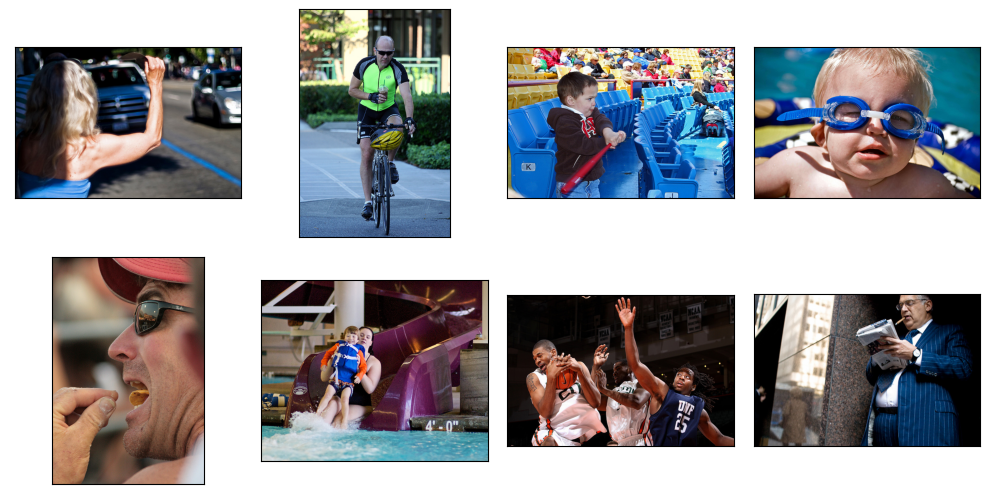

In [118]:
fig_train = plt.figure(figsize=(10,10))
for i in range(8):
    fig_train.add_subplot(4, 4, i+1)
    plt.imshow(all_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


##  Предобработка


Объединяем имеющиеся данные по колонкам 'image' и 'query_id'

In [119]:

df = train_dataset.merge(expert_ann, on=['image', 'query_id'], how='left').merge(crowd_ann,
                                     on=['image', 'query_id'], how='left')

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   score_1      5822 non-null   int64  
 4   score_2      5822 non-null   int64  
 5   score_3      5822 non-null   int64  
 6   ratio_plus   2329 non-null   float64
 7   count_plus   2329 non-null   float64
 8   count_minus  2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


In [121]:
df.head()

,image,query_id,query_text,score_1,score_2,score_3,ratio_plus,count_plus,count_minus
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.0,3.0,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN


In [122]:
df[['image', 'query_id', 'query_text']].describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Как видно из таблицы, в тренировочном датасете у нас 1000 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Построение сводной экспертной оценки
Используем метод голосования:
- если 2 эксперта поставили одинаковую оценку, она считается верной
- если все три оценки разные, такое описание отбрасывается

In [123]:
#функция, которая принимает три оценки и возвращает одну
def vot(x1, x2, x3):
    if x1 == x2 or x1 == x3:
        return x1
    elif x2 == x3:
        return x2
    else:
        return None

In [124]:
df['experts'] = df.apply(
    lambda x: vot(x['score_1'], x['score_2'], x['score_3']), axis=1)

In [125]:
df = df.dropna(subset=['experts'])

In [126]:
#масштабируем даные
scaler = MinMaxScaler()
df["experts"] = scaler.fit_transform(df[["experts"]])

In [127]:
df.head()

,image,query_id,query_text,score_1,score_2,score_3,ratio_plus,count_plus,count_minus,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.0,3.0,0.0,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.000000


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5821
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5696 non-null   object 
 1   query_id     5696 non-null   object 
 2   query_text   5696 non-null   object 
 3   score_1      5696 non-null   int64  
 4   score_2      5696 non-null   int64  
 5   score_3      5696 non-null   int64  
 6   ratio_plus   2258 non-null   float64
 7   count_plus   2258 non-null   float64
 8   count_minus  2258 non-null   float64
 9   experts      5696 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 489.5+ KB


In [129]:
df = df[['image', 'query_id', 'query_text', 'experts']]

In [130]:
df.head()

,image,query_id,query_text,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


In [131]:
df.shape

(5696, 4)

В столбцах с краундсорсинговыми оценками больше половины данных отсутствует. Поэтому в качестве итоговой примем оценку экспертов с учетом голосования и масштабирования.
 df['experts'] - целевая переменая.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

1. Определяем плохие комментарии.
- Последовательно ищем слова из стоп-листа child_stop в заданном тексте text.
- Возвращаем True, если нашлось хотя бы одно слово
2. Удаляем найденные изображения с детьми:
- у `query_id`  плохих комментариев отрезаем два последних символа и получаем список плохих изображений.
- удаляем все записи, содержащие эти изображения

In [132]:
nlp = spacy.load("en_core_web_sm")

In [133]:
%%time
def preprocess(text):
    text = text.lower()
    spacy_results = nlp(text)
    text = ' '.join([token.lemma_ for token in spacy_results])
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text

CPU times: total: 0 ns
Wall time: 0 ns


In [134]:
%%time
df['query_text'] = df['query_text'].apply(preprocess)

CPU times: total: 34.8 s
Wall time: 57.9 s


In [135]:
def child_text(text):
    res = False
    for w in BLOCK_WORDS:
        res |= text.find(w) > -1
    return res

In [136]:
df['child'] = df.apply(
    lambda x: child_text(x['query_text']), axis=1)

In [137]:
df.head()

,image,query_id,query_text,experts,child
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.000000,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.000000,True
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.333333,True
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,1.000000,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.000000,True


In [138]:
child_images = df[df['child'] == True]['query_id']


In [139]:
child_images = [x[:-2] for x in child_images]

In [140]:
child_images = set(child_images)

In [141]:
df = df.drop(
    df[df['image'].isin(child_images)].index, axis=0).reset_index()

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       4008 non-null   int64  
 1   image       4008 non-null   object 
 2   query_id    4008 non-null   object 
 3   query_text  4008 non-null   object 
 4   experts     4008 non-null   float64
 5   child       4008 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 160.6+ KB


Осталось 4008 записей.

In [143]:
df = df[['image', 'query_id', 'query_text', 'experts']]

In [144]:
df.head()

,image,query_id,query_text,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0


## 3. Векторизация изображений

Found 4008 validated image filenames.


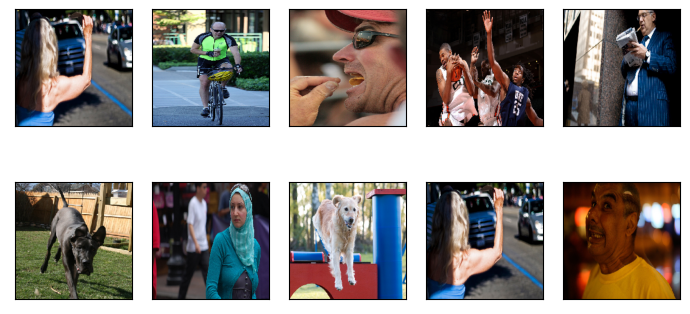

In [145]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory = path_train_image,
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_STATE,
        shuffle = False)

flow_train = train_gen_flow
features, target = next(flow_train)

fig = plt.figure(figsize=(7,5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [146]:
def create_model():
    backbone = ResNet50V2(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.0001),
                  metrics=['mae'])

    return model



def vectorize_pic(model, train_data):
    return model.predict(train_data)

In [147]:
%%time

pictures_emb = vectorize_pic(create_model(), flow_train)

251/251 [==============================] - 188s 744ms/step
CPU times: total: 5min 13s
Wall time: 3min 13s


In [148]:
pictures_emb.shape

(4008, 2048)

In [149]:
df.head()

,image,query_id,query_text,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,0.0


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [150]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words))

In [152]:

tf_matrix= vectorizer.fit_transform(df['query_text'])

In [153]:
tf_matrix.shape

(4008, 1158)

In [154]:
features_text = pd.DataFrame(tf_matrix.toarray())

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [155]:
features = np.concatenate((pictures_emb, features_text), axis=1)
features.shape

(4008, 3206)

In [156]:
target = np.array(df['experts'])
target.shape

(4008,)

## 6. Обучение модели предсказания соответствия

 Разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.


In [157]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)



train_indices, test_indices = next(gss.split(X=features,
                                             y=target,
                                             groups=df['image']
                                             ))

features_train, features_test = features[train_indices], features[test_indices]

target_train, target_test = target[train_indices], target[test_indices]

In [158]:
scaler = StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

В качестве метрики используем среднее абсолютное отклонение MAE. MAE достаточно проста в трактовке – она возвращает среднюю абсолютную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже MAE, тем лучше модель соответствует набору данных.

### Линейная регрессия

In [159]:
%%time
model = LinearRegression()

model.fit(features_train, target_train)
train_score = mean_squared_error(target_train,model.predict(features_train))
test_score = mean_squared_error(target_test,model.predict(features_test))

print('train_score =' , train_score)
print('test_score =' , test_score)

train_score = 0.04271171303073933
test_score = 2.8821593656736175e+26
CPU times: total: 31.2 s
Wall time: 7.09 s


### Ridge

In [160]:
%%time
model = Ridge()

model.fit(features_train, target_train)
train_score = mean_squared_error(target_train,model.predict(features_train))
test_score = mean_squared_error(target_test,model.predict(features_test))

print('train_score =' , train_score)
print('test_score =' , test_score)

train_score = 0.03473137090904857
test_score = 0.1291450385732445
CPU times: total: 3.77 s
Wall time: 724 ms


### Catboost

In [161]:
%%time
model_cat = CatBoostRegressor(verbose=0,
                          random_state=RANDOM_STATE)
model_cat.fit(features_train, target_train)
train_score = mean_squared_error(target_train,model_cat.predict(features_train))
test_score = mean_squared_error(target_test,model_cat.predict(features_test))

print('train_score =' , train_score)
print('test_score =' , test_score)


train_score = 0.01619655245480866
test_score = 0.0642932846453608
CPU times: total: 16min 36s
Wall time: 3min 23s


### Нейронная сеть

In [162]:
features_train.shape

(2787, 3206)

In [163]:
NN = Sequential()
NN.add(Dense(3206, input_shape=(3206,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3206)              10281642  
                                                                 
 batch_normalization (Batch  (None, 3206)              12824     
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               820992    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 11116739 (42.41 MB)
Trainable params: 11

In [166]:
NN.fit(
    features_train, target_train,
    validation_data=(features_test, target_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10


88/88 - 11s - loss: 0.0821 - root_mean_squared_error: 0.2866 - val_loss: 0.4877 - val_root_mean_squared_error: 0.6984 - 11s/epoch - 120ms/step
Epoch 2/10
88/88 - 10s - loss: 0.2042 - root_mean_squared_error: 0.4519 - val_loss: 0.5159 - val_root_mean_squared_error: 0.7183 - 10s/epoch - 112ms/step
Epoch 3/10
88/88 - 10s - loss: 0.1637 - root_mean_squared_error: 0.4046 - val_loss: 0.5044 - val_root_mean_squared_error: 0.7102 - 10s/epoch - 110ms/step
Epoch 4/10
88/88 - 10s - loss: 0.1380 - root_mean_squared_error: 0.3715 - val_loss: 0.5125 - val_root_mean_squared_error: 0.7159 - 10s/epoch - 109ms/step
Epoch 5/10
88/88 - 10s - loss: 0.1285 - root_mean_squared_error: 0.3584 - val_loss: 0.4967 - val_root_mean_squared_error: 0.7048 - 10s/epoch - 111ms/step
Epoch 6/10
88/88 - 10s - loss: 0.1169 - root_mean_squared_error: 0.3418 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037 - 10s/epoch - 109ms/step
Epoch 7/10
88/88 - 10s - loss: 0.1175 - root_mean_squared_error: 0.3428 - val_loss: 0.4

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [170]:
test_datagen = ImageDataGenerator(rescale=1/255.)
flow_test = test_datagen.flow_from_dataframe(
dataframe = test_images,
directory = path_test,
x_col = 'image',
y_col = None,
target_size = (224, 224),
batch_size = 16,
class_mode = 'input',
seed = RANDOM_STATE,
shuffle = False)

Found 100 validated image filenames.


In [171]:
pic_emb = vectorize_pic(create_model(), flow_test)


7/7 [==============================] - 4s 503ms/step


In [ ]:
pic_emb = pd.DataFrame(pic_emb)

### Функция проверки модели (с выводом предупреждения)

In [172]:
def lemm(x):
    spacy_results = nlp(x)
    new = ([token.lemma_ for token in spacy_results])
    return new

In [173]:
tf_matrix.shape

(4008, 1158)

In [174]:
def definitioin_picture(text):

    lemmas = lemm(text)

    # Выводим предупреждение
    if any(lemma in BLOCK_WORDS for lemma in lemmas):
        print('\n' + '*' * 40, text, '*' * 40)
        print('\nThis image is unavailable in your country in compliance with local laws.\n')

    else:
        features_text = lemm(text)
        features_text = pd.DataFrame(vectorizer.transform(features_text).toarray())
        features_text = np.resize((features_text),(pic_emb.shape[0], tf_matrix.shape[1]))
        features = np.concatenate((pic_emb, features_text), axis=1)
        features = scaler.transform(features)
        predictions = model_cat.predict(features)
        test_images['pred'] = np.reshape(predictions, (predictions.shape[0],))

        # Топ 5 картинок
        top_df = test_images.sort_values(by='pred', ascending=False).head(5)
        top = top_df['image'].tolist()
        top_score = top_df['pred'].tolist()

        print('\n' + '*' * 40, text, '*' * 40 + '\n')

        fig = plt.figure(figsize=(15,5))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0

        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(path_test + top[i])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(test_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'red'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(path_test + test_queries.iloc[test_queries[test_queries['query_text'] == text].index[0]]['image'])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

### Выбираем 5 случайных запросов.

In [175]:
samples = test_queries.sample(5)
text_test = list(samples['query_text'])
text_test

['A man riding a wakeboard on a lake',
 'little boy playing basketball in the grass',
 'Two children stand in the grass while a white dog bites one of their sweaters .',
 'A little girl leans over the side of a wall to feed ducks in the water .',
 'Three people are looking into photographic equipment .']


**************************************** A man riding a wakeboard on a lake ****************************************



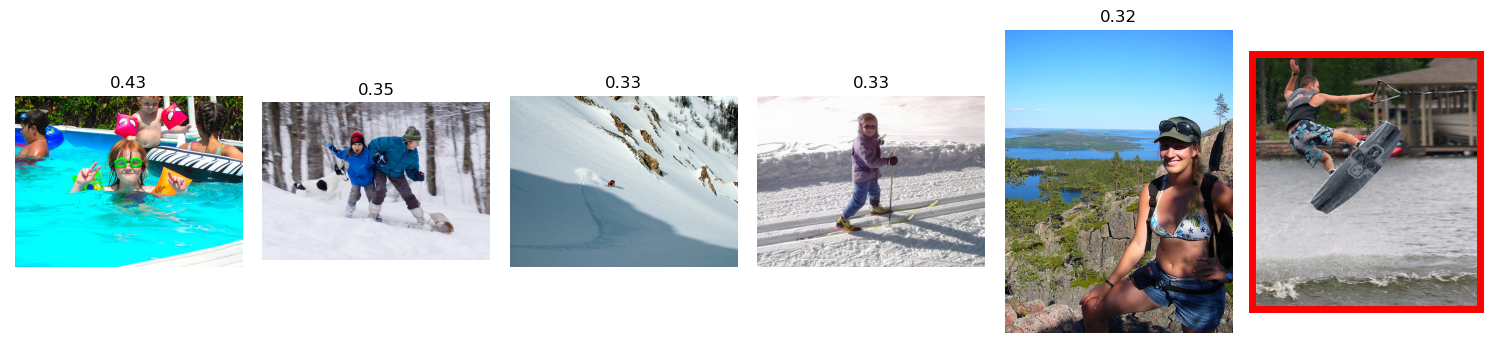


**************************************** little boy playing basketball in the grass ****************************************

This image is unavailable in your country in compliance with local laws.


**************************************** Two children stand in the grass while a white dog bites one of their sweaters . ****************************************

This image is unavailable in your country in compliance with local laws.


**************************************** A little girl leans over the side of a wall to feed ducks in the water . ****************************************

This image is unavailable in your country in compliance with local laws.


**************************************** Three people are looking into photographic equipment . ****************************************



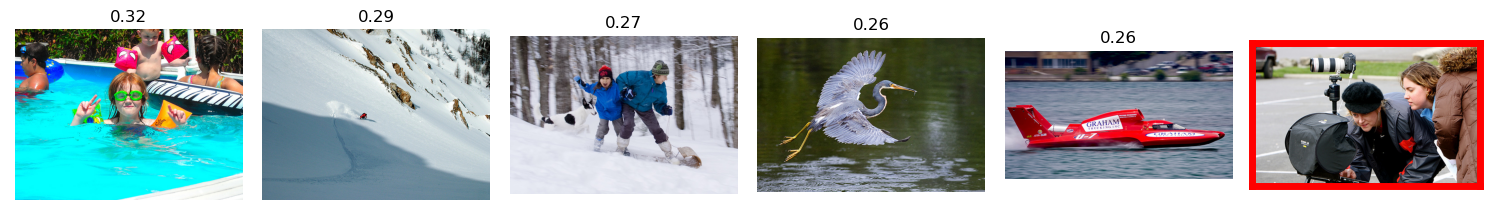

In [176]:
for text in text_test:
    definitioin_picture(text)

**Вывод**:

- загрузили и взглянули на данные;
- провели исследовательский анализ данных, объединили данные в общий датасет;
- удалили описания и изображения, попадающие под ограничения законодательства;
- векторизовали изображения с помощью ResNet50;
- векторизовали текстовые данные;
- обучили три модели, у которых получили следующие метрики: MSE линейной регрессии – 5,6, MSE Catboost'а -0,11 , MSE нейронной сети – 0.18
- провели тестирование модели.
